## Accelerate Inference: Neural Network Pruning

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *

print(tf.version.VERSION)

2.12.0


In [6]:
# untar
!tar -xvzf drive/MyDrive/dataset/dataset.tar.gz
# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


In [7]:
# Define the neural network architecture (don't change this)

model = models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5), input_shape=(25,25,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 activation (Activation)     (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 23, 23, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                        

In [9]:
# you can use the default hyper-parameters for training, 
# val accuracy ~72% after 50 epochs

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=32, epochs=50, 
                    validation_data=(val_images, val_labels)) # train for 50 epochs, with batch size 32

Epoch 1/50
703/703 [==============================] - 17s 8ms/step - loss: 1.5113 - accuracy: 0.3067 - val_loss: 1.3657 - val_accuracy: 0.4099
Epoch 2/50
703/703 [==============================] - 4s 5ms/step - loss: 1.3394 - accuracy: 0.4269 - val_loss: 1.2652 - val_accuracy: 0.4626
Epoch 3/50
703/703 [==============================] - 4s 6ms/step - loss: 1.2679 - accuracy: 0.4686 - val_loss: 1.1940 - val_accuracy: 0.5042
Epoch 4/50
703/703 [==============================] - 5s 7ms/step - loss: 1.2199 - accuracy: 0.4944 - val_loss: 1.1586 - val_accuracy: 0.5129
Epoch 5/50
703/703 [==============================] - 4s 6ms/step - loss: 1.1825 - accuracy: 0.5154 - val_loss: 1.1266 - val_accuracy: 0.5362
Epoch 6/50
703/703 [==============================] - 4s 5ms/step - loss: 1.1559 - accuracy: 0.5253 - val_loss: 1.1037 - val_accuracy: 0.5497
Epoch 7/50
703/703 [==============================] - 5s 7ms/step - loss: 1.1300 - accuracy: 0.5431 - val_loss: 1.0769 - val_accuracy: 0.5545
Epoch

In [10]:
model.save_weights('my_model_weights_orig.h5')
#model.load_weights('my_model_weights_orig.h5')
#weightsOrig = model.get_weights()
#model.set_weights(weightsOrig)
results = model.evaluate(val_images, val_labels, batch_size=128)


20/20 [==============================] - 0s 11ms/step - loss: 0.7165 - accuracy: 0.7251


22475
(25, 25, 3)
[0]


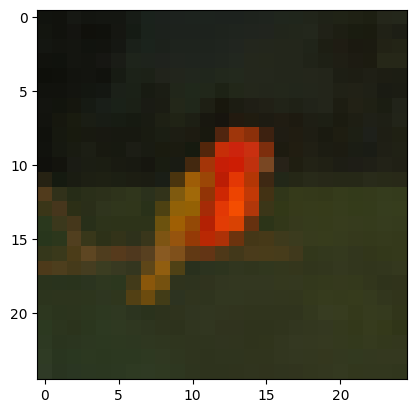

In [11]:
# sample images
index = 20 # 20 = bird(0)
print(len(train_images))
t = train_images[index,:]
print(t.shape)
tLab = train_labels[index]
print(tLab)
plt.imshow(t)

In [12]:
# Sensitivity of layer0 - not sensitive
model.load_weights('my_model_weights_orig.h5')
weights0 = model.get_weights()
convL0 = weights0[0]
print(convL0.shape)
val0 = np.sum(np.abs(convL0), axis = (0,1,2))
argsort0 = np.argsort(val0)
sort0 = np.sort(val0)
max0 = sort0[-1]
norm0 = sort0/max0
#plt.plot(np.arange(1, convL0.shape[3]+1, 1),norm0)
#plt.show
print(sort0/3)

(3, 3, 3, 32)
[0.5540273  0.5698393  0.56991833 0.5719471  0.5839515  0.5948068
 0.6070681  0.6089552  0.6220659  0.6248172  0.6276074  0.6414318
 0.6748615  0.67659765 0.6803631  0.6894421  0.691196   0.69295615
 0.699301   0.71389085 0.7172322  0.7175328  0.7309329  0.74355173
 0.7492826  0.7511079  0.79570705 0.7997647  0.8159158  0.8171746
 0.8788426  0.8880768 ]


20/20 [==============================] - 0s 4ms/step - loss: 2.0002 - accuracy: 0.1925


<function matplotlib.pyplot.show(close=None, block=None)>

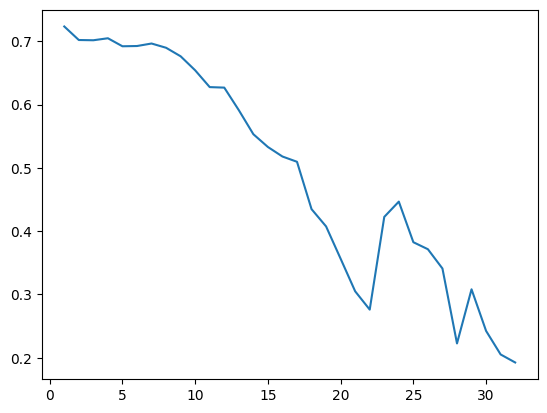

In [13]:
# Sensitivity of layer0 prune, no training - not sensitive
n0 = convL0.shape[3]
results0 = [0] *n0
for count in range(n0):
  c1zero = argsort0[count]
  weights0[0][:,:,:,c1zero] = 0
  weights0[1][c1zero] = 0
  weights0[2][:,:,c1zero,:] = 0
  model.set_weights(weights0)
  results0[count] = model.evaluate(val_images, val_labels, batch_size=128)[1]
plt.plot(np.arange(1, convL0.shape[3]+1, 1),results0)
plt.show

In [14]:
# Sensitivity of layer1 - sensitive
model.load_weights('my_model_weights_orig.h5')
weights1 = model.get_weights()
convL1 = weights1[2]
print(convL1.shape)
val1 = np.sum(np.abs(convL1), axis = (0,1,2))
argsort1 = np.argsort(val1)
sort1 = np.sort(val1)
max1 = sort1[-1]
norm1 = sort1/max1
#plt.plot(np.arange(1, convL1.shape[3]+1, 1),norm1)
#plt.show()
print(sort1/32)

(3, 3, 32, 32)
[4.2954286e-33 4.0447760e-01 4.8875156e-01 4.9634084e-01 4.9886793e-01
 5.0033605e-01 5.0237846e-01 5.1371837e-01 5.1390177e-01 5.1507097e-01
 5.1880538e-01 5.1951355e-01 5.2159715e-01 5.2358013e-01 5.2366513e-01
 5.2572948e-01 5.2587301e-01 5.2639246e-01 5.2739626e-01 5.2746260e-01
 5.3507525e-01 5.3533554e-01 5.3903067e-01 5.4337752e-01 5.5880284e-01
 5.5954581e-01 5.6208313e-01 5.6706887e-01 5.6832957e-01 5.6921887e-01
 5.7563937e-01 5.8512932e-01]


20/20 [==============================] - 0s 5ms/step - loss: 2.6251 - accuracy: 0.2071


<function matplotlib.pyplot.show(close=None, block=None)>

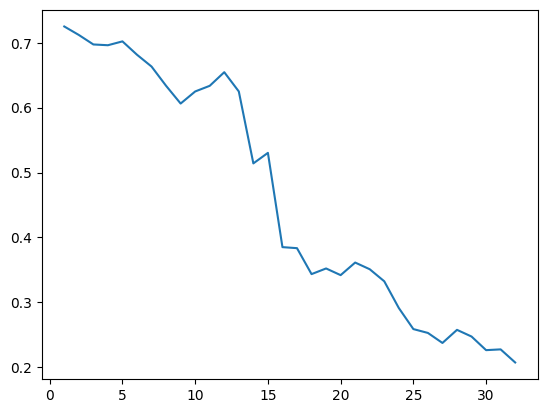

In [15]:
# Sensitivity of layer1 prune, no training - sensitive
n1 = convL1.shape[3]
results1 = [0] *n1
for count in range(n1):
  c1zero = argsort1[count]
  weights1[2][:,:,:,c1zero] = 0
  weights1[3][c1zero] = 0
  weights1[4][:,:,c1zero,:] = 0
  model.set_weights(weights1)
  results1[count] = model.evaluate(val_images, val_labels, batch_size=128)[1]
plt.plot(np.arange(1, convL1.shape[3]+1, 1),results1)
plt.show

In [16]:
# Sensitivity of layer2 - not sensitive
model.load_weights('my_model_weights_orig.h5')
weights2 = model.get_weights()
convL2 = weights2[4]
print(convL2.shape)
val2 = np.sum(np.abs(convL2), axis = (0,1,2))
argsort2 = np.argsort(val2)
sort2 = np.sort(val2)
max2 = sort2[-1]
norm2 = sort2/max2
#plt.plot(np.arange(1, convL2.shape[3]+1, 1),norm2)
#plt.show()
print(sort2/32)

(3, 3, 32, 64)
[0.3955293  0.40057057 0.4007143  0.4086272  0.40971014 0.41240248
 0.41262233 0.41516536 0.4188437  0.42043224 0.42073745 0.42090097
 0.42110795 0.42418832 0.42436856 0.42629942 0.42653877 0.42874667
 0.43079683 0.43200463 0.4341775  0.43439022 0.43488786 0.4356954
 0.43632835 0.43801516 0.43822694 0.43900326 0.439154   0.4443918
 0.44447774 0.4452873  0.44543517 0.4464041  0.4473662  0.45037383
 0.45121694 0.4552426  0.4567165  0.4582025  0.4611148  0.4623333
 0.4629838  0.46397334 0.46418077 0.46587723 0.46781984 0.46852112
 0.47465363 0.47515205 0.47589335 0.47760326 0.47782242 0.47799137
 0.48050717 0.48194256 0.4835598  0.48816115 0.48875266 0.48905104
 0.48973867 0.49421638 0.49681526 0.51648074]


20/20 [==============================] - 0s 4ms/step - loss: 1.8500 - accuracy: 0.1925


<function matplotlib.pyplot.show(close=None, block=None)>

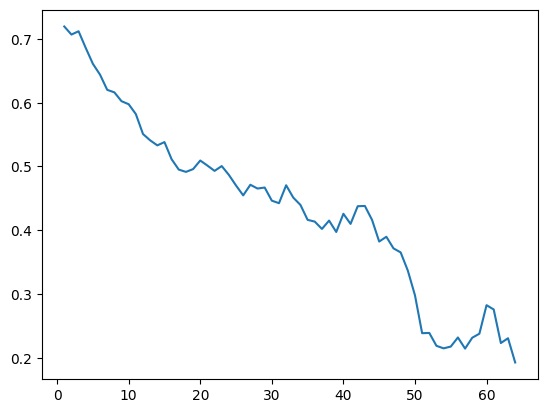

In [17]:
# Sensitivity of layer2 prune, no training - not sensitive
n2 = convL2.shape[3]
results2 = [0] *n2
for count in range(n2):
  c1zero = argsort2[count]
  weights2[4][:,:,:,c1zero] = 0
  weights2[5][c1zero] = 0
  weights2[6][:,:,c1zero,:] = 0
  model.set_weights(weights2)
  results2[count] = model.evaluate(val_images, val_labels, batch_size=128)[1]
plt.plot(np.arange(1, convL2.shape[3]+1, 1),results2)
plt.show

In [18]:
# Sensitivity of layer3 - sensitive
model.load_weights('my_model_weights_orig.h5')
weights3 = model.get_weights()
convL3 = weights3[6]
print(convL3.shape)
val3 = np.sum(np.abs(convL3), axis = (0,1,2))
argsort3 = np.argsort(val3)
sort3 = np.sort(val3)
max3 = sort3[-1]
norm3 = sort3/max3
#plt.plot(np.arange(1, convL3.shape[3]+1, 1),norm3)
#plt.show()
print(sort3/64)

(3, 3, 64, 64)
[4.2951329e-33 3.7609479e-01 3.8007015e-01 3.8224214e-01 3.8371363e-01
 3.8461921e-01 3.8524398e-01 3.8528842e-01 3.8585740e-01 3.8621262e-01
 3.8636366e-01 3.8684657e-01 3.8696200e-01 3.8782057e-01 3.8820386e-01
 3.8834277e-01 3.8960406e-01 3.9056680e-01 3.9100331e-01 3.9232150e-01
 3.9290959e-01 3.9342663e-01 3.9585298e-01 3.9603153e-01 3.9624405e-01
 3.9813888e-01 4.0059957e-01 4.0100563e-01 4.0129349e-01 4.0140307e-01
 4.0171695e-01 4.0210384e-01 4.0270713e-01 4.0275723e-01 4.0332958e-01
 4.0375701e-01 4.0416077e-01 4.0424398e-01 4.0509412e-01 4.0636870e-01
 4.0640724e-01 4.0657440e-01 4.0658018e-01 4.0713352e-01 4.0772673e-01
 4.0784538e-01 4.0882829e-01 4.0904534e-01 4.1006768e-01 4.1011599e-01
 4.1134849e-01 4.1149572e-01 4.1190892e-01 4.1380763e-01 4.1425666e-01
 4.1436347e-01 4.1645423e-01 4.1844979e-01 4.2361829e-01 4.2365241e-01
 4.2388541e-01 4.2471981e-01 4.2915207e-01 4.3521917e-01]


20/20 [==============================] - 0s 4ms/step - loss: 1.7064 - accuracy: 0.1925


<function matplotlib.pyplot.show(close=None, block=None)>

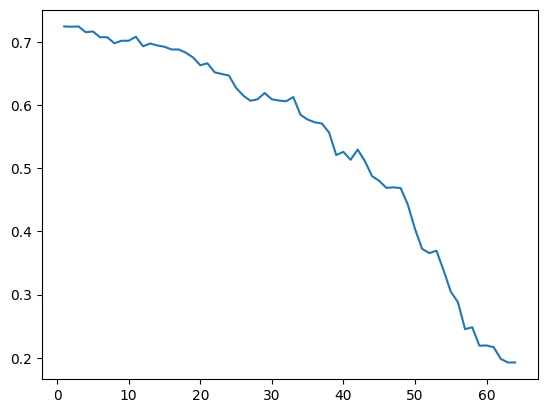

In [19]:
# Sensitivity of layer3 prune, no training - sensitive
n3 = convL3.shape[3]
results3 = [0] *n3
for count in range(n3):
  c1zero = argsort3[count]
  weights3[6][:,:,:,c1zero] = 0
  weights3[7][c1zero] = 0
  weights3[8][c1zero*16:16+c1zero*16,:] = 0
  model.set_weights(weights3)
  results3[count] = model.evaluate(val_images, val_labels, batch_size=128)[1]
plt.plot(np.arange(1, convL3.shape[3]+1, 1),results3)
plt.show

In [23]:
def mask(model,layer, idxs):
  weights = model.get_weights()
  maskedtf = np.ones(weights[layer].shape)
  if(layer % 2 == 0 and layer < 8 ):
    for i in idxs[int(layer/2)]:
      maskedtf[:,:,:,i] = 0
    return maskedtf
  elif (layer % 2 == 1 and layer < 8 ):
    for i in idxs[int(layer/2)]:
      maskedtf[i] = 0
    return maskedtf
  elif (layer == 8):
    for i in idxs[3]:
      maskedtf[i*16:16+i*16,:] = 0
    return maskedtf
  return maskedtf

def get_sparsity(model):
  num_zero = sum([(l == 0).sum() for l in model.get_weights()])
  total = np.sum([np.prod(v.shape) for v in model.get_weights()])
  return num_zero / total


In [25]:
model.load_weights('my_model_weights_orig.h5')

opt=keras.optimizers.Adam(learning_rate=0.0005, weight_decay=1e-6)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
train_labels_flt = train_labels.astype(np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels_flt))
train_dataloader = train_dataset.shuffle(buffer_size=len(train_labels), reshuffle_each_iteration=True).batch(32)
idxs = [[],[],[],[]]
pruned0 = 0
pruned1 = 0
pruned2 = 0
pruned3 = 0
tracked_acc = [] 
tracked_sparsity = []
#prune 50 filters total
for it in range(10):
  t1 = time.time()

  print("iteration: ", it)
  itWeights = model.get_weights()
  #prune 5 filters at a time
  for prune in range(5):

    if(pruned0 == 28):
      sort0[pruned0] = 100
    else:
      val0 = np.sum(np.abs(itWeights[0]), axis = (0,1,2))
      argsort0 = np.argsort(val0)
      sort0 = np.sort(val0/3)
    if(pruned1 == 28):
      sort1[pruned1] = 100
    else:
      val1 = np.sum(np.abs(itWeights[2]), axis = (0,1,2))
      argsort1 = np.argsort(val1)
      sort1 = np.sort(val1/32)
    if(pruned2 == 48):
      sort2[pruned2] = 100
    else:
      val2 = np.sum(np.abs(itWeights[4]), axis = (0,1,2))
      argsort2 = np.argsort(val2)
      sort2 = np.sort(val2/32)
    if(pruned3 == 48):
      sort3[pruned3] = 100
    else:
      val3 = np.sum(np.abs(itWeights[6]), axis = (0,1,2))
      argsort3 = np.argsort(val3)
      sort3 = np.sort(val3/64)

    if(sort0[pruned0] < sort1[pruned1] and sort0[pruned0] < sort2[pruned2] and sort0[pruned0] < sort3[pruned3]):
      idxs[0].append(pruned0)
      itWeights[0][:,:,:,pruned0] = 0
      itWeights[1][pruned0] = 0
      itWeights[2][:,:,pruned0,:] = 0
      pruned0 += 1
      if(pruned1 != 28):
        val1 = np.sum(np.abs(itWeights[2]), axis = (0,1,2))
        argsort1 = np.argsort(val1)
        sort1 = np.sort(val1/32)
    elif(sort1[pruned1] < sort0[pruned0] and sort1[pruned1] < sort2[pruned2] and sort1[pruned1] < sort3[pruned3]):
      idxs[1].append(pruned1)
      itWeights[2][:,:,:,pruned1] = 0
      itWeights[3][pruned1] = 0
      itWeights[4][:,:,pruned1,:] = 0
      pruned1 += 1
      if(pruned2 != 48):
        val2 = np.sum(np.abs(itWeights[4]), axis = (0,1,2))
        argsort2 = np.argsort(val2)
        sort2 = np.sort(val2/32)
    elif(sort2[pruned2] < sort0[pruned0] and sort2[pruned2] < sort1[pruned1] and sort2[pruned2] < sort3[pruned3]):
      idxs[2].append(pruned2)
      itWeights[4][:,:,:,pruned2] = 0
      itWeights[5][pruned2] = 0
      itWeights[6][:,:,pruned2,:] = 0
      pruned2 += 1
      if(pruned3 != 48):
        val3 = np.sum(np.abs(itWeights[6]), axis = (0,1,2))
        argsort3 = np.argsort(val3)
        sort3 = np.sort(val3/64)
    elif(sort3[pruned3] < sort0[pruned0] and sort3[pruned3] < sort1[pruned1] and sort3[pruned3] < sort2[pruned2]):
      idxs[3].append(pruned3)
      itWeights[6][:,:,:,pruned3] = 0
      itWeights[7][pruned3] = 0
      itWeights[8][pruned3*16:16+pruned3*16,:] = 0
      pruned3 += 1

  model.set_weights(itWeights)
  t2 = time.time()
  print("pruning time:",t2-t1)

  masked = [mask(model,i,idxs) for i in range(len(itWeights))] 
  t21 = time.time()
  print("mask time:",t21-t2)
  for epoch in range(5):
      for step, (data, target) in enumerate(train_dataloader):
          with tf.GradientTape() as tape:
              out = model(data, training=True) # proba after softmax
              loss_value = loss(target, out)
          gradients = tape.gradient(loss_value,model.trainable_weights)
          masked_gradients = [tf.math.multiply(masked[i],gradients[i]) for i in range(len(gradients))]
          opt.apply_gradients(zip(masked_gradients, model.trainable_weights))
          train_acc_metric.update_state(target, out)
      train_acc = train_acc_metric.result()
      print(f"Epoch {epoch}, Train Acc {train_acc:.3f}.")
      train_acc_metric.reset_states()
  
  model.save_weights(f"my_model_weights_{it}.h5")
  t3 = time.time()
  print("retraining time:",t3-t2)

  # eval
  model.compile(opt, loss, metrics=['accuracy'])
  results = model.evaluate(val_images, val_labels, batch_size=128) # [loss, acc]
  tracked_acc.append(results[1])
  sparsity = get_sparsity(model)
  tracked_sparsity.append(sparsity)
  print(f'Iter: {it}, Acc: {results[1]:.3f}, Sparsity: {sparsity:.3f}')

iteration:  0
pruning time: 0.013259410858154297
mask time: 0.05108952522277832
Epoch 0, Train Acc 0.711.
Epoch 1, Train Acc 0.718.
Epoch 2, Train Acc 0.730.
Epoch 3, Train Acc 0.741.
Epoch 4, Train Acc 0.749.
retraining time: 188.10876870155334
20/20 [==============================] - 0s 5ms/step - loss: 0.7646 - accuracy: 0.7046
Iter: 0, Acc: 0.705, Sparsity: 0.074
iteration:  1
pruning time: 0.01215219497680664
mask time: 0.06573057174682617
Epoch 0, Train Acc 0.736.
Epoch 1, Train Acc 0.745.
Epoch 2, Train Acc 0.757.
Epoch 3, Train Acc 0.763.
Epoch 4, Train Acc 0.773.
retraining time: 161.09174990653992
20/20 [==============================] - 0s 4ms/step - loss: 0.7205 - accuracy: 0.7331
Iter: 1, Acc: 0.733, Sparsity: 0.079
iteration:  2
pruning time: 0.011830568313598633
mask time: 0.05249810218811035
Epoch 0, Train Acc 0.766.
Epoch 1, Train Acc 0.771.
Epoch 2, Train Acc 0.778.
Epoch 3, Train Acc 0.785.
Epoch 4, Train Acc 0.791.
retraining time: 187.14707922935486
20/20 [========

In [26]:
#prune 50 filters total
for it in range(10,20):
  t1 = time.time()

  print("iteration: ", it)
  itWeights = model.get_weights()
  #prune 5 filters at a time
  for prune in range(5):

    if(pruned0 == 28):
      sort0[pruned0] = 100
    else:
      val0 = np.sum(np.abs(itWeights[0]), axis = (0,1,2))
      argsort0 = np.argsort(val0)
      sort0 = np.sort(val0/3)
    if(pruned1 == 28):
      sort1[pruned1] = 100
    else:
      val1 = np.sum(np.abs(itWeights[2]), axis = (0,1,2))
      argsort1 = np.argsort(val1)
      sort1 = np.sort(val1/32)
    if(pruned2 == 48):
      sort2[pruned2] = 100
    else:
      val2 = np.sum(np.abs(itWeights[4]), axis = (0,1,2))
      argsort2 = np.argsort(val2)
      sort2 = np.sort(val2/32)
    if(pruned3 == 48):
      sort3[pruned3] = 100
    else:
      val3 = np.sum(np.abs(itWeights[6]), axis = (0,1,2))
      argsort3 = np.argsort(val3)
      sort3 = np.sort(val3/64)

    if(sort0[pruned0] < sort1[pruned1] and sort0[pruned0] < sort2[pruned2] and sort0[pruned0] < sort3[pruned3]):
      idxs[0].append(pruned0)
      itWeights[0][:,:,:,pruned0] = 0
      itWeights[1][pruned0] = 0
      itWeights[2][:,:,pruned0,:] = 0
      pruned0 += 1
      if(pruned1 != 28):
        val1 = np.sum(np.abs(itWeights[2]), axis = (0,1,2))
        argsort1 = np.argsort(val1)
        sort1 = np.sort(val1/32)
    elif(sort1[pruned1] < sort0[pruned0] and sort1[pruned1] < sort2[pruned2] and sort1[pruned1] < sort3[pruned3]):
      idxs[1].append(pruned1)
      itWeights[2][:,:,:,pruned1] = 0
      itWeights[3][pruned1] = 0
      itWeights[4][:,:,pruned1,:] = 0
      pruned1 += 1
      if(pruned2 != 48):
        val2 = np.sum(np.abs(itWeights[4]), axis = (0,1,2))
        argsort2 = np.argsort(val2)
        sort2 = np.sort(val2/32)
    elif(sort2[pruned2] < sort0[pruned0] and sort2[pruned2] < sort1[pruned1] and sort2[pruned2] < sort3[pruned3]):
      idxs[2].append(pruned2)
      itWeights[4][:,:,:,pruned2] = 0
      itWeights[5][pruned2] = 0
      itWeights[6][:,:,pruned2,:] = 0
      pruned2 += 1
      if(pruned3 != 48):
        val3 = np.sum(np.abs(itWeights[6]), axis = (0,1,2))
        argsort3 = np.argsort(val3)
        sort3 = np.sort(val3/64)
    elif(sort3[pruned3] < sort0[pruned0] and sort3[pruned3] < sort1[pruned1] and sort3[pruned3] < sort2[pruned2]):
      idxs[3].append(pruned3)
      itWeights[6][:,:,:,pruned3] = 0
      itWeights[7][pruned3] = 0
      itWeights[8][pruned3*16:16+pruned3*16,:] = 0
      pruned3 += 1

  model.set_weights(itWeights)
  t2 = time.time()
  print("pruning time:",t2-t1)

  masked = [mask(model,i,idxs) for i in range(len(itWeights))] 
  t21 = time.time()
  print("mask time:",t21-t2)
  for epoch in range(5):
      for step, (data, target) in enumerate(train_dataloader):
          with tf.GradientTape() as tape:
              out = model(data, training=True) # proba after softmax
              loss_value = loss(target, out)
          gradients = tape.gradient(loss_value,model.trainable_weights)
          masked_gradients = [tf.math.multiply(masked[i],gradients[i]) for i in range(len(gradients))]
          opt.apply_gradients(zip(masked_gradients, model.trainable_weights))
          train_acc_metric.update_state(target, out)
      train_acc = train_acc_metric.result()
      print(f"Epoch {epoch}, Train Acc {train_acc:.3f}.")
      train_acc_metric.reset_states()
  
  model.save_weights(f"my_model_weights_{it}.h5")
  t3 = time.time()
  print("retraining time:",t3-t2)

  # eval
  model.compile(opt, loss, metrics=['accuracy'])
  results = model.evaluate(val_images, val_labels, batch_size=128) # [loss, acc]
  tracked_acc.append(results[1])
  sparsity = get_sparsity(model)
  tracked_sparsity.append(sparsity)
  print(f'Iter: {it}, Acc: {results[1]:.3f}, Sparsity: {sparsity:.3f}')

iteration:  10
pruning time: 0.0150604248046875
mask time: 0.05165672302246094
Epoch 0, Train Acc 0.663.
Epoch 1, Train Acc 0.672.
Epoch 2, Train Acc 0.672.
Epoch 3, Train Acc 0.677.
Epoch 4, Train Acc 0.678.
retraining time: 167.87076592445374
20/20 [==============================] - 0s 5ms/step - loss: 0.8550 - accuracy: 0.6760
Iter: 10, Acc: 0.676, Sparsity: 0.166
iteration:  11
pruning time: 0.01173257827758789
mask time: 0.056139469146728516
Epoch 0, Train Acc 0.650.
Epoch 1, Train Acc 0.659.
Epoch 2, Train Acc 0.662.
Epoch 3, Train Acc 0.667.
Epoch 4, Train Acc 0.668.
retraining time: 166.62863993644714
20/20 [==============================] - 0s 5ms/step - loss: 0.8495 - accuracy: 0.6705
Iter: 11, Acc: 0.670, Sparsity: 0.166
iteration:  12
pruning time: 0.012077569961547852
mask time: 0.05105185508728027
Epoch 0, Train Acc 0.635.
Epoch 1, Train Acc 0.642.
Epoch 2, Train Acc 0.648.
Epoch 3, Train Acc 0.654.
Epoch 4, Train Acc 0.658.
retraining time: 157.39645648002625
20/20 [====

In [37]:
print(tracked_acc)
print(tracked_sparsity)

SyntaxError: ignored

In [40]:
round_acc = [ round(elem, 3) for elem in tracked_acc ]
round_sparsity = [ round(elem, 3) for elem in tracked_sparsity ]
print(round_acc)
print(round_sparsity)

[0.705, 0.733, 0.723, 0.724, 0.73, 0.733, 0.693, 0.704, 0.687, 0.684, 0.676, 0.67, 0.657, 0.648, 0.65, 0.659, 0.639, 0.64, 0.617, 0.624]
[0.074, 0.079, 0.079, 0.086, 0.093, 0.106, 0.119, 0.131, 0.141, 0.159, 0.166, 0.166, 0.166, 0.168, 0.171, 0.175, 0.178, 0.182, 0.185, 0.188]


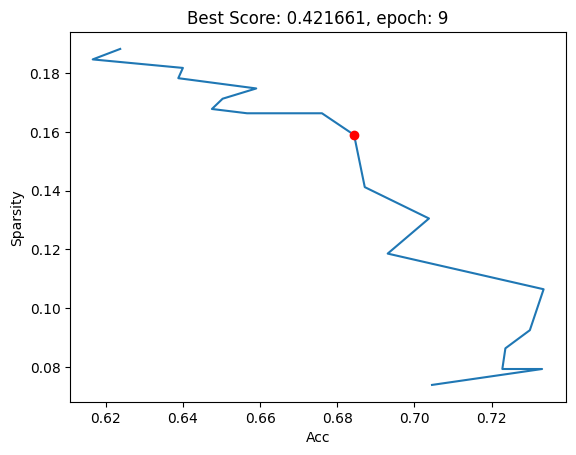

In [35]:
est_score = (np.array(tracked_acc) + np.array(tracked_sparsity)) / 2
plt.plot(tracked_acc, tracked_sparsity)
plt.plot(tracked_acc[np.argmax(est_score)], tracked_sparsity[np.argmax(est_score)], 'ro')
plt.xlabel('Acc')
plt.ylabel('Sparsity')
plt.title(f'Best Score: {max(est_score):3f}, epoch: {np.argmax(est_score)}')
plt.show()
  

In [34]:
# you need to save the model's weights, naming it 'my_model_weights.h5'
model.save_weights("drive/MyDrive/dataset/my_model_weights_9.h5")

# running this cell will immediately download a file called 'my_model_weights.h5'
from google.colab import files
files.download("drive/MyDrive/dataset/my_model_weights_9.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>